<a href="https://colab.research.google.com/github/pratyushsen1009/RainfallEstimation/blob/main/Theft_Detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install googlemaps pandas haversine gmaps -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [2]:
#converts the output list to a readable dataframe
def process_and_save_data(restaurants_list):

    if not restaurants_list:
        print("No restaurant data to process.")
        return

    processed_data = []
    for place in restaurants_list:
        processed_data.append({
            'Name': place.get('name', 'N/A'),
            'Latitude': place.get('geometry', {}).get('location', {}).get('lat', 'N/A'),
            'Longitude': place.get('geometry', {}).get('location', {}).get('lng', 'N/A'),
        })
    df = pd.DataFrame(processed_data)
    return df

In [4]:
# ==============================================================================
# 1. IMPORT ALL INSTALLED LIBRARIES
# ==============================================================================
import googlemaps
import pandas as pd
import time
import math
from haversine import haversine, Unit
from google.colab import userdata
import gmaps

print("Libraries installed and imported.")

# ==============================================================================
#  2. LOAD API KEY AND INITIALIZE CLIENT
# ==============================================================================
try:
    API_KEY = userdata.get('GOOGLE_API_KEY')
    gmaps_client = googlemaps.Client(key=API_KEY)
    print("API Key loaded and Google Maps client initialized.")
except Exception as e:
    print(f"Could not load API Key. Please add 'GOOGLE_API_KEY' to Colab Secrets. Error: {e}")
    API_KEY = None
    gmaps_client = None # Ensure client is None if API key fails

Libraries installed and imported.
API Key loaded and Google Maps client initialized.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/KEARNEY

/content/drive/MyDrive/KEARNEY


In [6]:
#--Grid-Approach to find all establishments in Tonk (5km radius)
def get_all_places_in_area(gmaps_client, location_name, total_radius_km, place_types):
    #FINDING RESTAURANTS FOR ALL PLACE TYPES
    if not gmaps_client:
        print("Google Maps client is not initialized.")
        return None

    # --- Step 1: Find the center of our main search area ---
    try:
        geocode_result = gmaps_client.geocode(location_name)
        if not geocode_result:
            print(f"Error: Could not find coordinates for '{location_name}'.")
            return None
        center_point = (geocode_result[0]['geometry']['location']['lat'],
                        geocode_result[0]['geometry']['location']['lng'])
        print(f"Search center for '{location_name}': {center_point}")
    except Exception as e:
        print(f"An API error occurred during geocoding: {e}")
        return None

    # --- Step 2: Generate a grid of points to search from ---
    # The grid spacing ensures the 1km radius search circles overlap.
    search_points = [center_point]
    grid_spacing_km = 1.5
    lat_deg_per_km = 1.0 / 111.0
    lon_deg_per_km = 1.0 / (111.0 * math.cos(math.radians(center_point[0])))

    steps = int(total_radius_km / grid_spacing_km)
    for i in range(-steps, steps + 1):
        for j in range(-steps, steps + 1):
            if i == 0 and j == 0:
                continue
            new_lat = center_point[0] + i * grid_spacing_km * lat_deg_per_km
            new_lon = center_point[1] + j * grid_spacing_km * lon_deg_per_km
            new_point = (new_lat, new_lon)

            # Only add points inside the main search radius
            if haversine(center_point, new_point, unit=Unit.KILOMETERS) <= total_radius_km:
                search_points.append(new_point)

    print(f"\nGenerated a grid of {len(search_points)} search points to cover the {total_radius_km}km radius.")

    # --- Step 3: Search each grid point for each type and de-duplicate ---
    all_places = {} # Using place_id as key for automatic de-duplication

    for i, point in enumerate(search_points):
        print(f"--> Searching grid point {i+1} of {len(search_points)}...")
        for place_type in place_types:
            try:
                # Make the initial API request
                response = gmaps_client.places_nearby(
                    location=point,
                    radius=1000,  # 1km radius for each grid search
                    type=place_type
                )

                for place in response.get('results', []):
                    all_places[place['place_id']] = place

                # Handle pagination for each search
                next_page_token = response.get('next_page_token')
                while next_page_token:
                    time.sleep(2)  # Mandatory delay before next page request
                    response = gmaps_client.places_nearby(page_token=next_page_token)
                    for place in response.get('results', []):
                        all_places[place['place_id']] = place
                    next_page_token = response.get('next_page_token')

            except Exception as e:
                print(f"    Error searching for '{place_type}' at this grid point: {e}")
                continue # Move to the next type or point

    print(f"\nSearch complete. Found a total of {len(all_places)} unique places.")
    return list(all_places.values())

In [7]:
#Executing the finder function here....
if __name__ == '__main__':
    # --- Example Usage ---
    # Replace 'YOUR_API_KEY' with your actual Google Maps API key
    try:
        gmaps = googlemaps.Client(key=API_KEY)

        # A list of types representing various commercial establishments
        commercial_types_to_find = [
          'store', 'restaurant', 'cafe', 'bar', 'shopping_mall',
          'bank', 'atm', 'pharmacy', 'supermarket', 'bakery', 'hotel',  'hospital',
          'school',
          'showroom',
          'wedding_hall',
          'car_repair', 'movie_theater', 'light_industry', 'gym', 'mall'
        ]

        # Get the list of nearby places
        found_places = get_all_places_in_area(
            gmaps_client=gmaps,
            location_name="Tonk,Rajasthan",
            total_radius_km=5.0,
            place_types=commercial_types_to_find
        )
        if found_places:
            print("--Success")
        else:
            print("No establishments found.")

    except NameError:
        print("\nERROR: Please replace 'YOUR_API_KEY' with your actual API key.")
    except ImportError:
        print("\nERROR: Please install required libraries: pip install googlemaps haversine")
    except Exception as e:
        print(f"An error occurred during execution: {e}")

Search center for 'Tonk,Rajasthan': (26.1659063, 75.7962852)

Generated a grid of 37 search points to cover the 5.0km radius.
--> Searching grid point 1 of 37...
--> Searching grid point 2 of 37...
--> Searching grid point 3 of 37...
--> Searching grid point 4 of 37...
--> Searching grid point 5 of 37...
--> Searching grid point 6 of 37...
--> Searching grid point 7 of 37...
--> Searching grid point 8 of 37...
--> Searching grid point 9 of 37...
--> Searching grid point 10 of 37...
--> Searching grid point 11 of 37...
--> Searching grid point 12 of 37...
--> Searching grid point 13 of 37...
--> Searching grid point 14 of 37...
--> Searching grid point 15 of 37...
--> Searching grid point 16 of 37...
--> Searching grid point 17 of 37...
--> Searching grid point 18 of 37...
--> Searching grid point 19 of 37...
--> Searching grid point 20 of 37...
--> Searching grid point 21 of 37...
--> Searching grid point 22 of 37...
--> Searching grid point 23 of 37...
--> Searching grid point 24 of 3

In [8]:
if found_places:
    # Convert to a pandas DataFrame for easy viewing
    comb_df = process_and_save_data(found_places)
    print(f"\nSuccessfully created a DataFrame with {len(comb_df)} entries.")
#comb_df -- contains list of establishments of given types in search radius


Successfully created a DataFrame with 2325 entries.


In [5]:
df_raw_1 = pd.read_excel('TON1_2113110MASTER.xlsx')
df_raw_2 = pd.read_excel('MASTER_OLD.xlsx')

In [6]:
columns_to_keep = ['ACCNO', 'TADESC', 'LONGITUDE', 'LATTITUDE', 'NAME'] #only keep these details for a house
df_raw_1 = df_raw_1[columns_to_keep]
df_raw_2 = df_raw_2[columns_to_keep]
df_raw = pd.concat([df_raw_1, df_raw_2], ignore_index=True) #combine the two files containing raw data
allowed_tadesc = ['DS', 'DOMESTIC', 'NDS', 'NDS-HT', 'NDS-LT', 'NON DOMESTIC','AG','AG-FLAT(G)','AG-FLAT(G-24)','AG-MTR(FRM)','AG-MTR(G)','AG-MTR(G-24)','AG-MTR(NUR)','AGRICULTURE'] #list of TADESCs we are concerned with
df = df_raw[df_raw['TADESC'].isin(allowed_tadesc)] #final df containing all the houses
df.dropna(inplace = True)
df.rename(columns = {'LATTITUDE': 'LATITUDE'},inplace = True)

<ipython-input-6-2070810024>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
<ipython-input-6-2070810024>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'LATTITUDE': 'LATITUDE'},inplace = True)


In [7]:
# breaking down into three categories
TADESC_DS = ['DS', 'DOMESTIC']
TADESC_NDS = ['NDS', 'NDS-HT', 'NDS-LT', 'NON DOMESTIC']
TADESC_AG = ['AG','AG-FLAT(G)','AG-FLAT(G-24)','AG-MTR(FRM)','AG-MTR(G)','AG-MTR(G-24)','AG-MTR(NUR)','AGRICULTURE']

In [8]:
df_ds = df[df['TADESC'].isin(TADESC_DS)]
df_nds = df[df['TADESC'].isin(TADESC_NDS)]
df_ag = df[df['TADESC'].isin(TADESC_AG)]

In [13]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
#------MINIMUM DISTANCE WITH DS
houses_rad = np.deg2rad(df_ds[['LATITUDE', 'LONGITUDE']].values) #lat-long data for DS meters
restaurants_rad = np.deg2rad(comb_df[['Latitude', 'Longitude']].values)
# Build BallTree with houses
tree = BallTree(houses_rad, metric='haversine')
# Query nearest neighbor for each restaurant
distances, indices = tree.query(restaurants_rad, k=1)
# Convert distance from radians to meters (Earth radius ≈ 6371 km)
distances_m = distances.flatten() * 6371000
# Add results to restaurants dataframe
comb_df['nearest_house_index'] = indices.flatten()
comb_df['distance_m'] = distances_m
# Map house details
comb_df['nearest_house_lat'] = df_ds.iloc[comb_df['nearest_house_index'], df_ds.columns.get_loc('LATITUDE')].values
comb_df['nearest_house_lon'] = df_ds.iloc[comb_df['nearest_house_index'], df_ds.columns.get_loc('LONGITUDE')].values
comb_df['nearest_house_accno'] = df_ds.iloc[comb_df['nearest_house_index'], df_ds.columns.get_loc('ACCNO')].values
comb_df['nearest_house_name'] = df_ds.iloc[comb_df['nearest_house_index'], df_ds.columns.get_loc('NAME')].values

In [14]:
#-------MINIMUM DISTANCE WITH NDS
houses_rad = np.deg2rad(df_nds[['LATITUDE', 'LONGITUDE']].values) #lat-long data for NDS meters
# Build BallTree with houses
tree = BallTree(houses_rad, metric='haversine')
# Query nearest neighbor for each restaurant
distances, indices = tree.query(restaurants_rad, k=1)
# Convert distance from radians to meters (Earth radius ≈ 6371 km)
distances_m = distances.flatten() * 6371000
# Add results to restaurants dataframe
comb_df['nearest_nds_index'] = indices.flatten()
comb_df['nds_distance_m'] = distances_m
# Map house details
comb_df['nearest_nds_lat'] = df_nds.iloc[comb_df['nearest_nds_index'], df_nds.columns.get_loc('LATITUDE')].values
comb_df['nearest_nds_lon'] = df_nds.iloc[comb_df['nearest_nds_index'], df_nds.columns.get_loc('LONGITUDE')].values
comb_df['nearest_nds_accno'] = df_nds.iloc[comb_df['nearest_nds_index'], df_nds.columns.get_loc('ACCNO')].values
comb_df['nearest_nds_name'] = df_nds.iloc[comb_df['nearest_nds_index'], df_nds.columns.get_loc('NAME')].values


In [15]:
comb_df.drop(columns = ['nearest_house_index','nearest_nds_index'],inplace = True)

In [16]:
comb_df_filtered = comb_df[(comb_df['distance_m'] < 5) & (comb_df['nds_distance_m'] > 5)]

In [17]:
comb_df_filtered.to_csv('suspects.csv') #-- final list of suspects that we'll carry forward for the next method.
#don't need to run this part again, once saved retrieved from csv file

In [9]:
def getCategory(tadesc):
  if tadesc in TADESC_DS:
    return 'Domestic'
  elif tadesc in TADESC_NDS:
    return 'Non Domestic'
  elif tadesc in TADESC_AG:
    return 'Agriculture'
df['category'] = df['TADESC'].apply(getCategory)

<ipython-input-9-600909100>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['TADESC'].apply(getCategory)


In [10]:
df_knn = df.copy() #make a copy of the original dataframe and then modify it for weighted KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Prepare Data for KNN ---(also take the outliers)
X = df_knn[['LATITUDE', 'LONGITUDE']]
y_true_labels = df_knn['category']
le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_labels) #category encoder (changes text-based categories into numbers)

# --- 2. Build and Use the Weighted KNN Model ---
# Initialize the KNN model with weights='distance' for weighted KNN
# This gives closer neighbors more influence on the vote.
knn_weighted = KNeighborsClassifier(n_neighbors = 1)

# Train the model
knn_weighted.fit(X, y_true_encoded)

# Predict the labels for the entire dataset
y_pred_encoded = knn_weighted.predict(X)

# Decode predictions back to string labels
y_pred_labels = le.inverse_transform(y_pred_encoded) #inverse category encoder (changes back into the original category names)
df_knn['KNN_Predicted'] = y_pred_labels

# --- 3. Identify and Isolate Mismatched Points ---
df_mismatched = df_knn[df_knn['category'] != df_knn['KNN_Predicted']]

print(f"Found {len(df_mismatched)} mis-categorized points.")


Found 194 mis-categorized points.


In [24]:
df_mismatched_filtered = df_mismatched[df_mismatched['category'] == 'Agriculture']

In [22]:
df_mismatched_filtered = df_mismatched[(df_mismatched['category'] == 'Domestic') & (df_mismatched['KNN_Predicted'] == 'Non Domestic')]  #~311

In [25]:
len(df_mismatched_filtered)

4

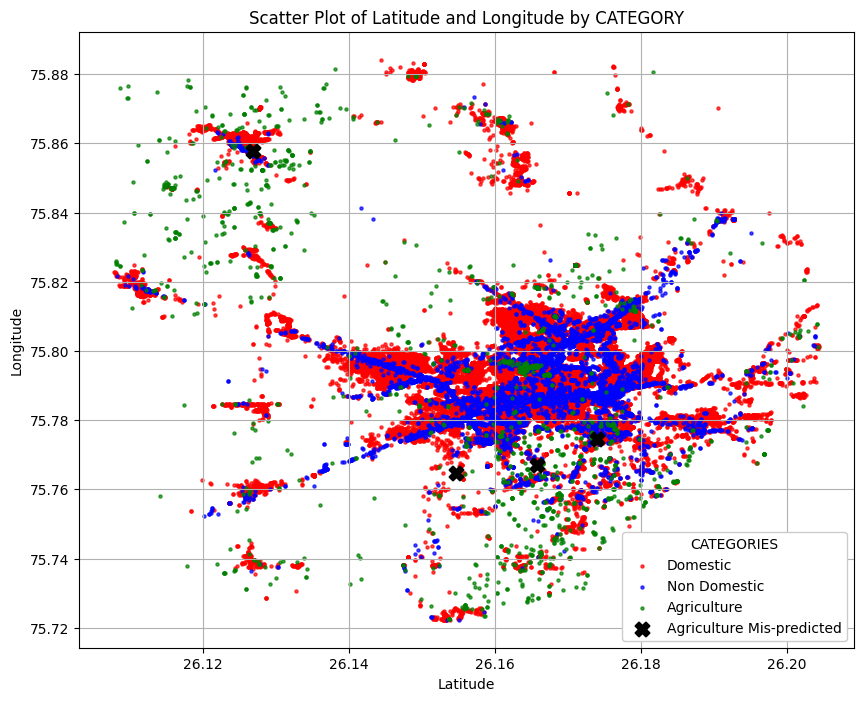

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# remove outliers (some points were anomalous and it was messing up the plot)
# threshold is defined here
lat_threshold_low = df['LATITUDE'].quantile(0.005)
lat_threshold_high = df['LATITUDE'].quantile(0.995)
lon_threshold_low = df['LONGITUDE'].quantile(0.005)
lon_threshold_high = df['LONGITUDE'].quantile(0.995)

# Filter the DataFrame
df_filtered = df[
    (df['LATITUDE'] >= lat_threshold_low) & (df['LATITUDE'] <= lat_threshold_high) &
    (df['LONGITUDE'] >= lon_threshold_low) & (df['LONGITUDE'] <= lon_threshold_high)
]

# Create a scatter plot with color coding
plt.figure(figsize=(10, 8))

# Get unique TADESC types and create a color map
categories = df_filtered['category'].unique()

color_map = {
    'Domestic': 'red',
    'Non Domestic': 'blue',
    'Agriculture': 'green'
}
# Plot each TADESC type with a different color
for i, category in enumerate(categories):
    subset = df_filtered[df_filtered['category'] == category]
    plt.scatter(subset['LATITUDE'], subset['LONGITUDE'], color=color_map[category], label=category, s=5, alpha=0.7)

if not df_mismatched_filtered.empty:
    plt.scatter(df_mismatched_filtered['LATITUDE'], df_mismatched_filtered['LONGITUDE'],
                marker='X',           # Use an 'X' marker
                color='black',      # A bright, distinct color
                s=100,                # Larger size
                linewidths=1.5,       # Thicker lines
                edgecolors='black',   # Black edge for contrast
                label="Agriculture Mis-predicted")

plt.title('Scatter Plot of Latitude and Longitude by CATEGORY')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid(True)
plt.legend(title='CATEGORIES',framealpha = 1.0)
plt.show()

Running DBSCAN algorithm...


<ipython-input-11-2997739981>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DBSCAN_Cluster'] = db.labels_
<ipython-input-11-2997739981>:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('viridis', n_clusters + 1)


Estimated number of clusters: 44
Estimated number of noise points: 681
Identifying mismatched points based on cluster identity...
Found 20406 potentially mis-categorized points inside clusters.
Generating plot...


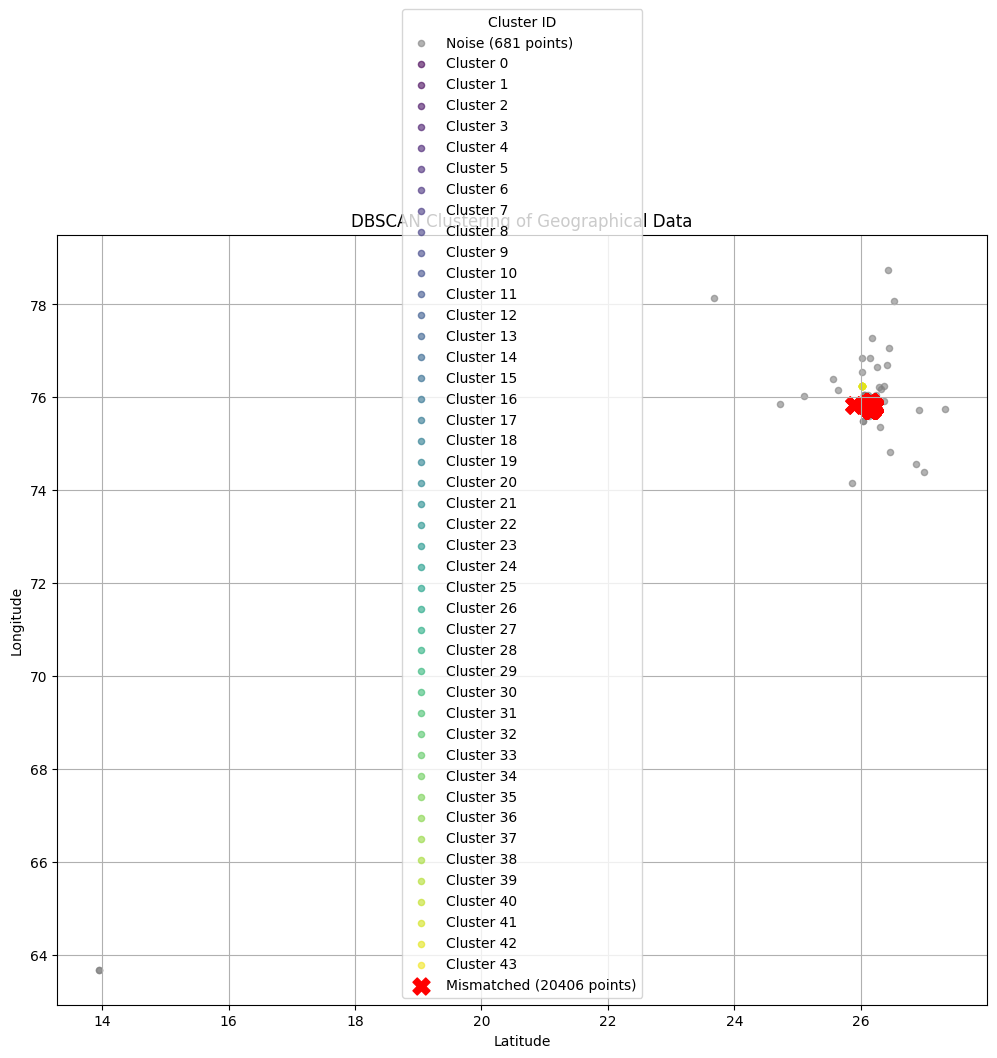

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random

# --- 2. Run DBSCAN Clustering ---
print("Running DBSCAN algorithm...")
# Select only the coordinates for clustering
coords = df[['LATITUDE', 'LONGITUDE']]

# Scale the data - this is very important for DBSCAN's distance metric
coords_scaled = StandardScaler().fit_transform(coords)

# Initialize and run the DBSCAN model
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
db = DBSCAN(eps=0.03, min_samples=10).fit(coords_scaled)

# Add the cluster labels from DBSCAN to the DataFrame
# Noise points are given the label -1
df['DBSCAN_Cluster'] = db.labels_
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')


# --- 3. Identify Mismatched Points ---
print("Identifying mismatched points based on cluster identity...")
mismatched_points = []

# Iterate through each cluster found by DBSCAN (excluding noise)
for cluster_id in range(n_clusters):
    # Get all points belonging to this cluster
    cluster_df = df[df['DBSCAN_Cluster'] == cluster_id]

    # Find the dominant original label (the "mode") in this cluster
    if not cluster_df.empty:
        dominant_label = cluster_df['TADESC'].mode()[0]
        # Find all points in this cluster whose original label is NOT the dominant one
        mismatches = cluster_df[cluster_df['TADESC'] != dominant_label]
        if not mismatches.empty:
            mismatched_points.append(mismatches)

# Combine all mismatched points into a single DataFrame
if mismatched_points:
    df_mismatched = pd.concat(mismatched_points)
    print(f'Found {len(df_mismatched)} potentially mis-categorized points inside clusters.')
else:
    df_mismatched = pd.DataFrame(columns=df.columns) # Create empty df if no mismatches
    print("Found no mis-categorized points inside clusters.")


# --- 4. Generate the Visualization ---
print("Generating plot...")
plt.figure(figsize=(12, 10))

# Create a color palette for the clusters
# We add 1 to n_clusters to have a separate color for noise if it exists
cluster_colors = plt.cm.get_cmap('viridis', n_clusters + 1)

# Plot each cluster with a different color
for cluster_id in range(-1, n_clusters):
    # Set label and color for the legend
    if cluster_id == -1:
        label = f'Noise ({n_noise} points)'
        color = 'gray'
    else:
        label = f'Cluster {cluster_id}'
        color = cluster_colors(cluster_id)

    # Plot the points for the current cluster
    points = df[df['DBSCAN_Cluster'] == cluster_id]
    plt.scatter(points['LATITUDE'], points['LONGITUDE'],
                s=20, color=color, label=label, alpha=0.6)

# Highlight the mismatched points on top with a distinct red 'X'
if not df_mismatched.empty:
    plt.scatter(df_mismatched['LATITUDE'], df_mismatched['LONGITUDE'],
                s=150, c='red', marker='X',
                label=f'Mismatched ({len(df_mismatched)} points)')

plt.title('DBSCAN Clustering of Geographical Data')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid(True)
plt.legend(title='Cluster ID')

# Save and show the plot
plt.savefig('dbscan_cluster_plot.png', dpi=300)
plt.show()